### Studying Vulnerabilities in Package Dependency Networks
Code for analysing strong connectivity and building the condensation of package dependency networks. A condensation is a network where strongly connected componentes are contracted into single vertices, thus producing a directed acyclic graph (DAG).

Uses input files in adjacency list format produced by _write_adjlist_ method from NetworkX.

In [1]:
import networkx as nx
from statistics import mean 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def condensation_report(G):
    """
    Searchs for strongly connected components (SCCs) in the given directed 
    graph and builds its condensation. 
    Outputs some stats about SCCs count and intra-SCC properties.
    
    Parameters
    ----------
    G : NetworkX Graph
        Directed graph with cycles.
    Returns
    -------
    GC : Condensation of G
    scc_sizes : Sizes of SCCs in G
    scc_out : Out degrees of SCCs in G
    scc_in : In degrees of SCCs in G
    """
    if nx.is_directed_acyclic_graph(G):
        print("Network is acyclic")
        return
    print('Finding strongly connected components (SCCs)...')
    scc = nx.strongly_connected_components(G)
    scc = list(scc)
    print('Analysing SCCs...')
    GC = nx.condensation(G,scc)
    scc_sizes, scc_out, scc_in, scc_count = [], [], [], 0
    
    for n in GC.nodes:
        if len(GC.nodes[n]['members'])>1:
            scc_sizes.append(len(GC.nodes[n]['members']))
            scc_out.append(GC.out_degree[n])
            scc_in.append(GC.in_degree[n])
            scc_count += 1
    
    print("--------------------------------------------------------")
    print(f'Original graph has {len(G)} nodes and {len(scc)} SCCs')
    print(f'{len(G)-len(scc)}({round(100*(len(G)-len(scc))/len(G),4)}%)'+
          ' nodes of the original graph are in SCCs larger than one node')
    print()
    print(f'{scc_count} SCCs larger than one node:')
    print(f'   Size: MIN {min(scc_sizes)}, MAX {max(scc_sizes)}, AVG { round(mean(scc_sizes),2)}')
    plt.plot(sorted(scc_sizes, reverse=True))
    plt.show()
    print(f'   Out degree: MIN {min(scc_out)}, MAX {max(scc_out)}, AVG { round(mean(scc_out),2)}')
    plt.plot(sorted(scc_out, reverse=True))
    plt.show()
    print(f'   In degree: MIN {min(scc_in)}, MAX {max(scc_in)}, AVG { round(mean(scc_in),2)}')
    plt.plot(sorted(scc_in, reverse=True))
    plt.show()
    return GC, scc_sizes, scc_out, scc_in

In [9]:
G = nx.read_adjlist("pypi-dependencies-net-2020-01-12.bz2", create_using=nx.DiGraph())

Finding strongly connected components (SCCs)...
Analysing SCCs...
--------------------------------------------------------
Original graph has 50766 nodes and 50690 SCCs
76(0.1497%) nodes of the original graph are in SCCs larger than one node

51 SCCs larger than one node:
   Size: MIN 2, MAX 7, AVG 2.49


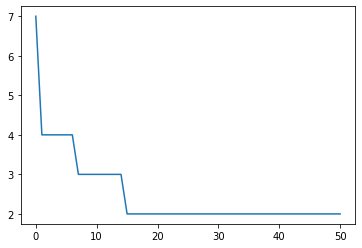

   Out degree: MIN 0, MAX 1057, AVG 36.24


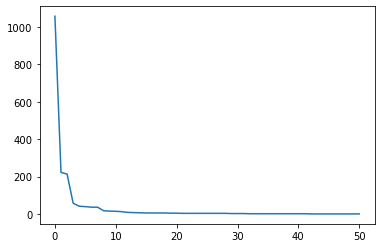

   In degree: MIN 0, MAX 34, AVG 11.37


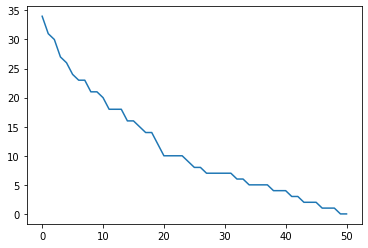

In [10]:
GC, scc_sizes, scc_out, scc_in = condensation_report(G)

As _networkx.strongly_connected_components()_ uses [Tarjan's algorithm](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm), SCCs are returned in reverse topological order and hence the condensation graph GC has its nodes indexed in reversed topological order.

The condensation graph includes all the mapping information we will need, a dictionary of original names and node indexes as a graph attribute, _GC.graph\['mapping'\]_ and a set of members for each contracted SCC at node attribute level.

In [11]:
GC.graph['mapping']

{'1pass': 0,
 'simple-pbkdf2': 1,
 'Alarmageddon': 2,
 'ansiblator': 3,
 'ansiblereporter': 4,
 'augploy': 5,
 'bang': 6,
 'battleschool': 7,
 'debops': 8,
 'dst': 9,
 'IM': 10,
 'suitable': 11,
 'pytest-ansible': 12,
 'onespacemedia-server-management': 13,
 'ansible-inventory-grapher': 14,
 'pytest-molecule': 15,
 'testaid': 16,
 'molecule-azure': 17,
 'molecule-inspec': 18,
 'molecule': 19,
 'lintreview': 20,
 'ansible-review': 21,
 'ansible-lint-nunit': 22,
 'galaxy-importer': 23,
 'ansible-lint': 24,
 'ansible-modules-hashivault': 25,
 'ara': 26,
 'myria-cluster': 27,
 'rally': 28,
 'os-faults': 29,
 'paternoster': 30,
 'linchpin': 31,
 'ansible-alicloud': 32,
 'polemarch': 33,
 'antshell': 34,
 'enoslib': 35,
 'ants-client': 36,
 'agileutil': 37,
 'kayobe': 38,
 'tripleo-upgrade': 39,
 'kolla-cli': 40,
 'polemarch-ansible': 41,
 'opera': 42,
 'ansible-later': 43,
 'bboss': 44,
 'bigsudo': 45,
 'cumulus-vxconfig': 46,
 'mixbytes-tank': 47,
 'quantum-queen': 48,
 'accelpy': 49,
 'mo

In [12]:
GC.nodes[12]['members']

{'pytest-ansible'}

In [5]:
# Saving the complete structure as a compressed pickled object
nx.write_gpickle(GC,'pypi-dependencies-net-2020-01-12_dag-model.bz2')